# 0. Setup of Paths

In [1]:
import os

In [2]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet'
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [3]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow', 'scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow', 'models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace', 'annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace', 'images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace', 'models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace', 'pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace', 'models', CUSTOM_MODEL_NAME),
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace', 'models', CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH': os.path.join('Tensorflow', 'workspace', 'models', CUSTOM_MODEL_NAME, 'tfjsexport'),  
    'TFLITE_PATH': os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH': os.path.join('Tensorflow', 'protoc'),
    'REALTIMEDETECTIONS_PATH': os.path.join('RealTimeDetections')
 }

In [4]:
files = {
    'PIPELINE_CONFIG': os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [ ]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

# 1. Downloading TF Models Pretrained Models from Tensorflow Model Zoo and Installing TFOD

In [ ]:
if os.name=='nt':
    !pip install wget
    import wget

In [ ]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

In [ ]:
# Install Tensorflow Object Detection 
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
    
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow/models/research/slim && pip install -e . 

In [ ]:
!pip list

In [ ]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

In [ ]:
!pip install tensorflow tensorflow-gpu --upgrade

In [ ]:
!pip install scipy

In [ ]:
!pip install tf-models-official

In [ ]:
!pip install tensorflow.io

In [ ]:
!pip list

In [ ]:
!python {VERIFICATION_SCRIPT}

In [ ]:
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

# 2. Creating the Label Map

In [ ]:
labels = [{'name':'licence', 'id':1}]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 3. Creating TF records

In [ ]:
# https://www.kaggle.com/datasets/andrewmvd/car-plate-detection?resource=download

In [ ]:
# IF RUNNING ON COLAB
ARCHIVE_FILES = os.path.join(paths['IMAGE_PATH'], 'archive.tar.gz')
if os.path.exists(ARCHIVE_FILES):
  !tar -zxvf {ARCHIVE_FILES}

In [ ]:
!pip install pytz

In [ ]:
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} 
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')} 

# 4. Copying Model Config to Training Folder

In [ ]:
if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

# 5. Updating Config For Transfer Learning

In [ ]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [ ]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [ ]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()  
    text_format.Merge(proto_str, pipeline_config)  

In [ ]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [ ]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

# 6. Training the model

In [ ]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [ ]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=10000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

In [ ]:
print(command)

In [ ]:
!pip install lvis

In [ ]:
!{command}

# 7. Evaluating the Model

In [ ]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])

In [ ]:
print(command)

In [ ]:
!{command}

# 8. Loading Trained Model From Checkpoint and Building a Detection Model

In [5]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [ ]:
!pip install GPUtil

In [6]:
import GPUtil
# Prevent GPU complete consumption
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try: 
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    except RunTimeError as e:
        print(e)

In [7]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-11')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 9. Detecting plate from an Image, OCR, Saving Results

In [ ]:
!pip install avro-python3

In [ ]:
!pip install opencv-python

In [8]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [9]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [10]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'TEST9.jpg')

ORIGINAL


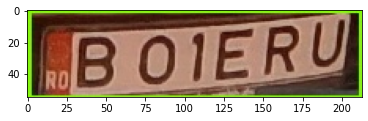

ORIGINAL


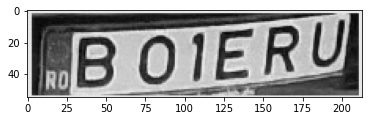

IMPROVED RESOLUTION


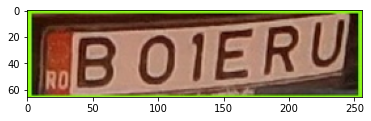

DETAILS ENHANCED


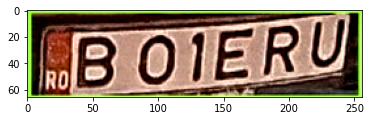

BILATERAL FILTER ENHANCED


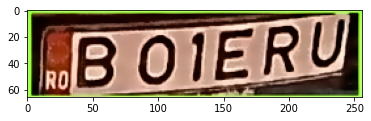

BILATERAL GRAY ENHANCED


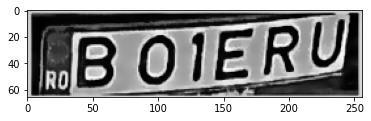

THRESH 1 ENHANCED


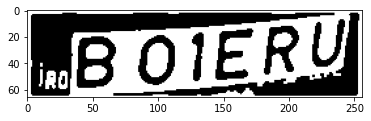

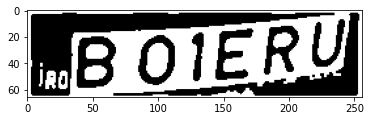

In [11]:
img_orig = cv2.imread(IMAGE_PATH)
print('ORIGINAL')
plt.imshow(img_orig)
plt.show()

img_orig_gray = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)
print('ORIGINAL')
plt.imshow(img_orig_gray, cmap='gray')
plt.show()

img_resized = cv2.resize(img_orig, None, fx=1.2, fy=1.2, interpolation=cv2.INTER_CUBIC)
print('IMPROVED RESOLUTION')
plt.imshow(img_resized)
plt.show()

img_detailsEnhanced = cv2.detailEnhance(img_resized, sigma_s=10, sigma_r=0.15)
print('DETAILS ENHANCED')
plt.imshow(img_detailsEnhanced)
plt.show()

img_BilateralFilterEnhanced = cv2.bilateralFilter(img_detailsEnhanced, 9, 75, 75)
print('BILATERAL FILTER ENHANCED')
plt.imshow(img_BilateralFilterEnhanced)
plt.show()

img_BilateralFilterEnhancedGray = cv2.cvtColor(img_BilateralFilterEnhanced, cv2.COLOR_BGR2GRAY)
print('BILATERAL GRAY ENHANCED')
plt.imshow(img_BilateralFilterEnhancedGray, cmap='gray')
plt.show()

img_threshEnhanced = cv2.threshold(cv2.medianBlur(img_BilateralFilterEnhancedGray, 3), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
print('THRESH 1 ENHANCED')
plt.imshow(img_threshEnhanced, cmap='gray')
plt.show()

backtorgb = cv2.cvtColor(img_threshEnhanced,cv2.COLOR_GRAY2RGB)

image_np = np.array(backtorgb)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

# OCR Filtering

In [ ]:
!pip install easyocr

In [ ]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

In [12]:
import easyocr

In [13]:
def filter_text(region, ocr_result, region_threshold):
    rectangle_size = region.shape[0]*region.shape[1]
    
    plate = [] 
    for result in ocr_result:
        length = np.sum(np.subtract(result[0][1], result[0][0]))
        height = np.sum(np.subtract(result[0][2], result[0][1]))
        
        if length*height / rectangle_size > region_threshold:
            plate.append(result[1])
    return plate

# OCR proccess and filtering

In [14]:
detection_threshold = 0.7
region_threshold = 0.6

In [15]:
def ocr_it(image, detections, detection_threshold, region_threshold):
    
    # Scores, boxes and classes above threhold
    scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
    boxes = detections['detection_boxes'][:len(scores)]
    classes = detections['detection_classes'][:len(scores)]
    
    # Full image dimensions
    width = image.shape[1]
    height = image.shape[0]
    
    # Apply ROI filtering and OCR
    for idx, box in enumerate(boxes):
        roi = box*[height, width, height, width]
        region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
        reader = easyocr.Reader(['en'])
        ocr_result = reader.readtext(region)
        
        text = filter_text(region, ocr_result, region_threshold)
        
        plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
        plt.show()
        print(text)
        return text, region

# Saving Results

In [16]:
import csv
import uuid
from datetime import datetime

In [17]:
def save_results(text, region):
    
    now = datetime.now()
    date_string = now.strftime('%y-%m-%d')
    print(date_string)
    time_string = now.strftime('%H-%M-%S')
    print(time_string)
    
    folder_path_images = 'RealTimeDetectionsImages\RealTimeDetections-{}'.format(date_string)
    img_name = '{}_{}.jpg'.format(time_string, uuid.uuid1())
    forlder_path_csv = 'RealTimeDetections'
    csv_filename = 'RealTimeDetections\RealTimeDetections-{}.csv'.format(date_string)
    
    if not os.path.exists(folder_path_images):
        if os.name == 'posix':
            !mkdir -p {folder_path_images}
        if os.name == 'nt':
            !mkdir {folder_path_images}
    
    if not os.path.exists(forlder_path_csv):
        if os.name == 'posix':
            !mkdir -p {forlder_path_csv}
        if os.name == 'nt':
            !mkdir {forlder_path_csv}
            
    cv2.imwrite(os.path.join(folder_path_images, img_name), region)
                
    with open(csv_filename, mode='a', newline='') as f:
        csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        if text == []:
            text = ['unreadable']
        csv_writer.writerow([date_string, time_string, img_name, text])
        

# 10. Real Time Detections from Webcam

In [18]:
import cv2

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


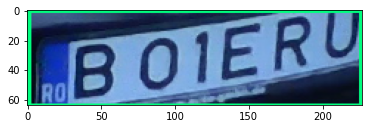

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


['B O1RY']
22-06-12
03-24-02


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


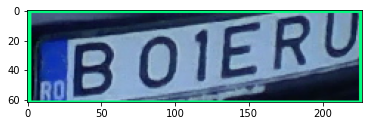

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


['B O1Ry']
22-06-12
03-24-06


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


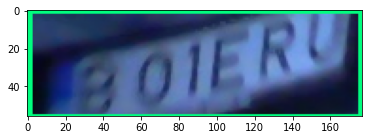

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


['GOIHRU']
22-06-12
03-24-16


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


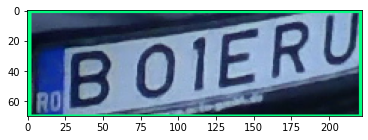

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


['B O1ERU']
22-06-12
03-24-29


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [24]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()

    #img_resized = cv2.resize(image_np_with_detections, None, fx=1.2, fy=1.2, interpolation=cv2.INTER_CUBIC)
    #img_detailsEnhanced = cv2.detailEnhance(img_resized, sigma_s=10, sigma_r=0.15)
    #img_BilateralFilterEnhanced = cv2.bilateralFilter(img_detailsEnhanced, 9, 75, 75)
    #img_BilateralFilterEnhancedGray = cv2.cvtColor(img_BilateralFilterEnhanced, cv2.COLOR_BGR2GRAY)
    #img_threshEnhanced = cv2.threshold(cv2.medianBlur(img_BilateralFilterEnhancedGray, 3), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    #backtorgb = cv2.cvtColor(img_threshEnhanced,cv2.COLOR_GRAY2RGB)
    
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections
    
    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)
    
    try:
        text, region = ocr_it(image_np_with_detections, detections, detection_threshold, region_threshold)
        save_results(text, region)
    except:
        pass

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

# 10. Freezing the Graph

In [ ]:
FREEZE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'exporter_main_v2.py ')

In [ ]:
command = "python {} --input_type=image_tensor --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(FREEZE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['OUTPUT_PATH'])

In [ ]:
print(command)

In [ ]:
!{command}

# 11. Conversion to TFJS

In [ ]:
!pip install tensorflowjs

In [ ]:
command = "tensorflowjs_converter --input_format=tf_saved_model --output_node_names='detection_boxes,detection_classes,detection_features,detection_multiclass_scores,detection_scores,num_detections,raw_detection_boxes,raw_detection_scores' --output_format=tfjs_graph_model --signature_name=serving_default {} {}".format(os.path.join(paths['OUTPUT_PATH'], 'saved_model'), paths['TFJS_PATH'])

In [ ]:
print(command)

In [ ]:
!{command}

# 12. Conversion to TFLite

In [ ]:
TFLITE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'export_tflite_graph_tf2.py ')

In [ ]:
command = "python {} --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(TFLITE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['TFLITE_PATH'])

In [ ]:
print(command)

In [ ]:
!{command}

In [ ]:
FROZEN_TFLITE_PATH = os.path.join(paths['TFLITE_PATH'], 'saved_model')
TFLITE_MODEL = os.path.join(paths['TFLITE_PATH'], 'saved_model', 'detect.tflite')

In [ ]:
command = "tflite_convert \
--saved_model_dir={} \
--output_file={} \
--input_shapes=1,300,300,3 \
--input_arrays=normalized_input_image_tensor \
--output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' \
--inference_type=FLOAT \
--allow_custom_ops".format(FROZEN_TFLITE_PATH, TFLITE_MODEL, )

In [ ]:
print(command)

In [ ]:
!{command}

# 13. Zipping and Exporting Models 

In [ ]:
!pip install google-colab

In [ ]:
!tar -czf models.tar.gz {paths['CHECKPOINT_PATH']}

In [ ]:
import google.colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from os import listdir
from os.path import isfile, join
import pandas as pd
from datetime import datetime

In [ ]:
def getDataFromCsv(elem):
    
    dataDate = pd.read_csv(os.path.join('RealTimeDetections', elem), header=None, usecols=[0])
    dataTime = pd.read_csv(os.path.join('RealTimeDetections', elem), header=None, usecols=[1])
    dataFileName = pd.read_csv(os.path.join('RealTimeDetections', elem), header=None, usecols=[2])
    dataPlate = pd.read_csv(os.path.join('RealTimeDetections', elem), header=None, usecols=[3])
    
    listDate = dataDate.values.tolist()
    listTime = dataTime.values.tolist()
    listFileName = dataFileName.values.tolist()
    listPlate = dataPlate.values.tolist()
    
    listDateNew = [elem[0] for elem in listDate]
    listTimeNew = [elem[0] for elem in listTime]
    listFileNameNew = [elem[0] for elem in listFileName]
    listPlateNew = [elem[0] for elem in listPlate]
    
    listPlateNewNew = []
    for elem in listPlateNew:
        elem = elem[2:-2]
        listPlateNewNew.append(elem)
     
    # print(listDateNew)
    # print()
    # print(listTimeNew)
    # print()
    # print(listFileNameNew)
    # print()
    # print(listPlateNewNew)
    # print()
    
    return [listDateNew, listTimeNew, listFileNameNew, listPlateNew]

csvfiles = [f for f in listdir('RealTimeDetections') if isfile(join('RealTimeDetections', f))]
csvfiles = csvfiles[1:]

returns = []
for elem in csvfiles:
    [listDateReturn, listTimeReturn, listFileNameReturn, listPlateReturn] = getDataFromCsv(elem)
    returns.append([listDateReturn, listTimeReturn, listFileNameReturn, listPlateReturn])
    
for elem in returns:
    print(elem)
    print()
    
for elem in returns:
    platesToPass = elem[3]
    datesToPass = elem[0]
    timestampsToPass = elem[1]
    filenamesToPass = elem[2]
    
    timestampsValids = []
    for i, timestampi in enumerate(timestampsToPass):
        timestampsValid = []
        timestamp1 = (datetime.strptime(timestampi,"%H-%M-%S").time())
        
        flag = True
        if(len(timestampsValids) != 0):
            for elem in timestampsValids:
                if timestamp1.strftime("%H-%M-%S") in elem:
                    flag = False
                    break
        
        if(timestampi != timestampsToPass[-1] and flag == True):
            for j, timestampj in enumerate(timestampsToPass[i+1:]):
                timestamp2 = (datetime.strptime(timestampj,"%H-%M-%S").time())
                print(f'{timestamp1}, {timestamp2}')
                if((timestamp1.hour == timestamp2.hour) and (timestamp1.minute == timestamp2.minute)):
                    if(timestamp1 not in timestampsValid):
                        timestampsValid.append(timestamp1.strftime("%H-%M-%S"))
                    if timestamp2 not in timestampsValid:
                        timestampsValid.append(timestamp2.strftime("%H-%M-%S"))
                    print('yes')
                else:
                    print('no')
                    break
        if(len(timestampsValid) != 0):
            timestampsValids.append(timestampsValid)
    print(timestampsValids)
    print()
    
# verificat, inlaturat alea goale, facut restul litelor pentru data placuta bla bla, merge doar cu un element?


In [ ]:
platesList1 = ['BLO65LBF', 'BLe654BP', 'unreadable', 'BLO654BP', 'BLO654BP', 'BLO6SLBP', 'BLO654BP', 'BLe654BP', 'BLe654BP', 'BLO654BP', 'BL265-ER', 'BLO654BP', 'BLO654BP', 'BLe654BP', 'BLP654BP', 'BLO654BP', 'BLP64BP']
platesList2 = ['MHIZDE1433', 'MHIZDE1433', 'MHIZDE1433', 'MHIZDE1433', 'MAIZ DE1433', 'MHI2 DE143', 'MHI2DE1433', 'MHIZ DE4433', 'MH12 DE 1432', 'MHIZ DE1433', 'HH12 DE1433', 'MHIZDE1433', 'HHIZDE1433']
platesList3 = ['SA0335CC', 'SA0335C0', 'FSA0335cq', 'SAv335c0', 'S133c0', 'SA0335C0']
platesList4 = ['0vooqu', 'Teooodz', 'Ie000dz', 'IVeoooo7', 'Tao000z', 'TVvoooo7', '1Vv00007', 'Vvoooo7', 'Vooodz', 'TVv00007', 'T9ooodz', 'Tvoooo7', 'T900dz']
platesList5 = ['ORU', 'BO1RU', 'BOIRU', 'BOE', 'TO1RU', 'B OIERU', 'TTERU', 'B OIERU']
platesList6 = ['8 007 BMW', '8 007 BMW', '8 007 BMW', 'B 007 BMW']


def processPlate(stringsUnreadable, dates, timestamps, filenames):
    
    print(f'Placute neprocesate:\n{stringsUnreadable}\n')
    
    strings = []
    for index, elem in enumerate(stringsUnreadable):
        if elem != "['unreadable']":
            strings.append(elem)
    
    counts_unreadable = []
    for elem in strings:
        counts_unreadable.append(strings.count(elem))
    maximum_unreadable = max(counts_unreadable)
    if(maximum_unreadable != "['unreadable']"):
        maximum_index_unreadable = counts_unreadable.index(maximum_unreadable)
        dateKept = dates[maximum_index_unreadable]
        timestampKept = timestamps[maximum_index_unreadable]
        filenameKept = filenames[maximum_index_unreadable]
    else:
        maximum_index_unreadable = random.randrange(0, len(count_unreadable))
        dateKept = dates[maximum_index_unreadable]
        timestampKept = timestamps[maximum_index_unreadable]
        filenameKept = filenames[maximum_index_unreadable]
    
    print(f'Numar de placute: {len(strings)}\n')
    print(f'Placute:\n{strings}\n')

    strings_sorted = strings
    strings_sorted.sort()
    print(f'Placute sortate:\n{strings_sorted}\n')

    strings_unique = set(strings)
    strings_unique = list(strings_unique)
    print(f'Placute fara dubluri:\n{strings_unique}\n')

    counts = []
    for elem in strings_unique:
        counts.append(strings.count(elem))
    print(f'Numar de aparitii fiecare placuta unica:\n{counts}\n')

    maximum = max(counts)
    maximum_index = counts.index(maximum)
    print(f'Cel mai mare numar de aparitii: {maximum}')
    print(f'Se afla la indexul: {maximum_index}\n')

    stringsValues = []
    stringsCounts = []
    if(counts.count(maximum) == 1):
        for index, elem in enumerate(strings_unique):
            if (len(elem) == len(strings_unique[maximum_index])):
                stringsValues.append(elem)
                stringsCounts.append(counts[index])
            else:
                print(f'{elem} stearsa din detectii!')
    elif(counts.count(maximum) == len(strings_unique)):
        for index, elem in enumerate(strings_unique):
            if (len(elem) == len(strings_unique[0])):
                stringsValues.append(elem)
                stringsCounts.append(counts[index])
    else:
        for index, elem in enumerate(strings_unique):
            if (len(elem) == len(strings_unique[maximum_index])):
                stringsValues.append(elem)
                stringsCounts.append(counts[index])

    print(f'\nPlacute luate in considerare:\n{stringsValues}')
    print(f'Cu numerele de apartii:\n{stringsCounts}\n')

    literePosibilePlacuta = []
    factoriPlacuta = []
    for i in range(0, len(strings_unique[maximum_index])):
        literePosibile = []
        factori = []
        for index, elem in enumerate(stringsValues):
            print(f'Litera de pe indexul {i} din placuta cu numarul {index} este {elem[i]} si are un factor de {stringsCounts[index]}')
            literaPosibila = elem[i]
            factor = counts[index]
            if literaPosibila not in literePosibile:
                literePosibile.append(literaPosibila)
                factori.append(factor)
            else:
                indexLiteraExistenta = literePosibile.index(literaPosibila)
                factori[indexLiteraExistenta] += factor
        print()
        literePosibilePlacuta.append(literePosibile)
        factoriPlacuta.append(factori)

    for i in range(0, len(strings_unique[maximum_index])):
        print(f'Pentru caracterul de pe indexul {i} luam in considerare: {literePosibilePlacuta[i]} cu factorii {factoriPlacuta[i]}')
    print()

    stringFinal = ''
    for index, elem in enumerate(literePosibilePlacuta):
        if(len(elem) == 1):
            print(f'Pentru indexul {index} am ales {elem[0]}')
            stringFinal = stringFinal + elem[0]
        else:
            maximum_local = max(factoriPlacuta[index])
            maximum_local_index = factoriPlacuta[index].index(maximum_local)
            print(f'Pentru indexul {index} am ales {elem[maximum_local_index]}')
            stringFinal = stringFinal + elem[maximum_local_index]

    print(f'\nPlacuta finala: {stringFinal}')
    print(f'\nPreluata la data de: {dateKept}')
    print(f'\nOra: {timestampKept}')
    print(f'\nFisierul: {filenameKept}')
    return(stringFinal)

# sa le scoata din acelasi minut